In [1]:
import sys
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../file_loader")
sys.path.append("../preprocessing-block")

import ecg_file_loader
from ecg_file_loader import ECGFileLoader

import rpeaks_finder
from rpeaks_finder import *

import ectopic_beats_filtering
from ectopic_beats_filtering import *

reload(ecg_file_loader)
reload(rpeaks_finder)
reload(ectopic_beats_filtering)

<module 'ectopic_beats_filtering' from '/Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/• src_blocks/check_codes/../preprocessing-block/ectopic_beats_filtering.py'>

In [2]:
loader = ECGFileLoader(use_s3=False)

In [3]:
processed_data = process_all_patients_rpeaks(loader, ['sub-001'])

INFO:rpeaks_finder:Processing R-peaks detection for 1 patients: ['sub-001']
INFO:rpeaks_finder:Loading data for patient sub-001
INFO:ecg_file_loader:Processing sub-001 run 01
INFO:ecg_file_loader:Processing sub-001 run 02
INFO:ecg_file_loader:Processing sub-001 run 03
INFO:ecg_file_loader:Processing sub-001 run 04
INFO:ecg_file_loader:Processing sub-001 run 05
INFO:ecg_file_loader:Processing sub-001 run 06
INFO:ecg_file_loader:Processing sub-001 run 07
INFO:ecg_file_loader:Processing sub-001 run 08
INFO:ecg_file_loader:Processing sub-001 run 09
INFO:rpeaks_finder:Processing sub-001 run 01
INFO:rpeaks_finder:ECG signal shape: (16721664,), sampling rate: 256.0 Hz
INFO:rpeaks_finder:Successfully processed sub-001 run 01: 72450 R-peaks detected
INFO:rpeaks_finder:Processing sub-001 run 02
INFO:rpeaks_finder:ECG signal shape: (5072896,), sampling rate: 256.0 Hz
INFO:rpeaks_finder:Successfully processed sub-001 run 02: 22104 R-peaks detected
INFO:rpeaks_finder:Processing sub-001 run 03
INFO:

In [4]:
processed_rr = process_dvc_for_session(processed_data['sub-001'][0], min_rr_s=0.3, max_rr_s=1.3)


--------------------------------------------------
Processing session 01 for patient sub-001
--------------------------------------------------
Initial state: 72449 RRs, 72450 timestamps.
--- Starting Ectopic Beat Filtering ---
Found 57 RR intervals > 1.3s. Deleting them to create gaps.
Found short RR interval (0.289s) at index 49661. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interval as an artifact.
Found short RR interval (0.293s) at index 31502. Analyzing merge options...
  > Right merge successful. New RR: 0.648s.
Found short RR interval (0.273s) at index 31486. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interval as an artifact.
Found short RR interval (0.270s) at index 16261. Analyzing merge options...
  > Right merge successful. New RR: 1.078s.
Found short RR interval (0.289s) at index 16227. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interva

In [5]:
rr_intervals = processed_rr['dvc_rr_intervals_ms']
timestamps = processed_rr['dvc_rpeak_times_s']

In [16]:
print(len(rr_intervals), len(timestamps[1:]))

72506 72506


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyhrv/time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


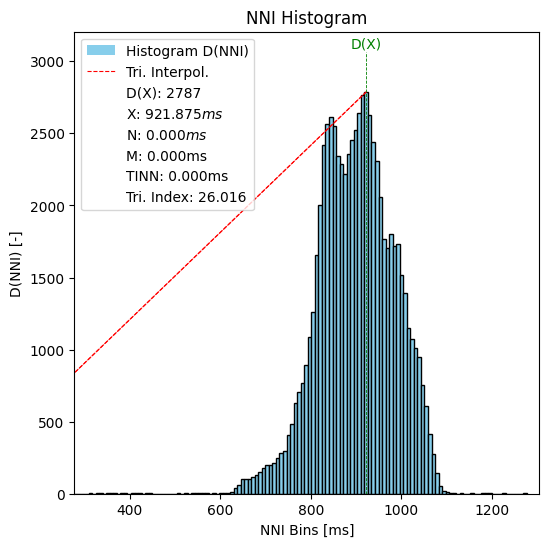

In [37]:
import pyhrv
import pyhrv.time_domain as td

results = td.time_domain(rr_intervals)

In [38]:
results

ReturnTuple(nni_counter=72506, nni_mean=900.8188223216009, nni_min=300.78125, nni_max=1281.25, hr_mean=67.21942162954706, hr_min=46.829268292682926, hr_max=199.4805194805195, hr_std=6.843016245975114, nni_diff_mean=22.327949132064308, nni_diff_min=0, nni_diff_max=921, sdnn=83.1034264484127, sdnn_index=33.5247358746849, sdann=73.67596725420566, rmssd=34.13911017714668, sdsd=25.825389250296475, nn50=5066, pnn50=6.987104337631887, nn20=30507, pnn20=42.07571891593683, nni_histogram=<Figure size 600x600 with 1 Axes>, tinn_n=0, tinn_m=0, tinn=0, tri_index=26.01578758521708)

In [18]:
from pyhrv.time_domain import time_domain
import pandas as pd

df = pd.DataFrame({'time': timestamps[1:], 'rr': rr_intervals})

In [23]:
from pyhrv.time_domain import time_domain

def compute_hrv_time_windows(df, window_minutes=5):
    window_seconds = window_minutes * 60
    start_time = df['time'].min()
    end_time = df['time'].max()
    
    results = []
    
    current_start = start_time
    while current_start + window_seconds <= end_time:
        current_end = current_start + window_seconds
        # Select RR intervals within this window
        window_rr = df[(df['time'] >= current_start) & (df['time'] < current_end)]['rr'].values
        
        if len(window_rr) > 1:  # need at least 2 intervals
            # Compute HRV features
            features = time_domain(rr_intervals=window_rr)
            features['start_time'] = current_start
            features['end_time'] = current_end
            results.append(features)
        
        # Move the window forward (non-overlapping)
        current_start += window_seconds
    
    return pd.DataFrame(results)


In [24]:
hrv_df = compute_hrv_time_windows(df, window_minutes=5)

TypeError: time_domain() got an unexpected keyword argument 'rr_intervals'